* This notebook was made to look at the plume position defined by $x = \frac{\iint xf(x,y)dxdy}{\iint f(x,y)dxdy}$, $y = \frac{\iint yf(x,y)dxdy}{\iint f(x,y)dxdy}$, $f(x,y) = \int \frac{S_{0}-S}{S_{0}}dz$, affected by winds and the Coriolis force. $S_{0}$ = 30.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import datetime, os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import StraTimeSeries as sts
import DetermineEdgePlume as DEP
import R_mixStuff as RS
from R_mixStuff import sites
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
octnof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
maynof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_T.nc')
jannof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [4]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted+1,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.nanmean(S[tst:ted+1,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [5]:
def threshold_whole_domain2(all_T,tst,ted,dep_ind,dep):
    """Plot the boundary of the plume and threshold salinity"""
    
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    ## plot plume edge on 
    S_thre,W = determine_plume_method2_onlysalinity(all_T,tst,ted,dep)
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(1,))
    print(S_thre)
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])

In [6]:
def area_plume(all_T,tst,ted,dep_ind,dep):
    """Return the indices of plume region based on definition"""
    jss  = []; iss = []; 
    S_thre,W = determine_plume_method2_onlysalinity(all_T,tst,ted,dep)
    for j in np.arange(130):
        for i in np.arange(157):
            if W[j,i] - S_thre >= 0.03:
                jss.append(j)
                iss.append(i)
    return jss, iss, S_thre,W

In [7]:
def test_boundary(jss,iss,all_T):
    fig, ax = plt.subplots(1,1,figsize = (8,5))
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])  
    ax.plot(lon[0,:],lat[0,:],'r-')
    ax.plot(lon[-1,:],lat[-1,:],'r-')
    ax.plot(lon[:,0],lat[:,0],'r-')
    ax.plot(lon[:,-1],lat[:,-1],'r-')
    for j, i in zip(jss,iss):
        ax.plot(lon[j,i],lat[j,i],'*')

In [8]:
def freshwater_xy(grid_T,tst,ted,dep_ind):
    """Calculate the freshwater over depths for all grid cells"""
    S0 = 30;
    S = grid_T.variables['vosaline'][tst:ted+1]
    ssh = grid_T.variables['sossheig']
    fresh = np.zeros(S.shape)
    for t in np.arange(ted+1-tst):
        for z in np.arange(dep_ind):
            adj_ssh = 1+ssh[t+tst]/np.sum(e3t[:]*tmask[:],axis = 0)
            fresh[t,z] = (1-S[t,z]/S0)*e3t[z]*adj_ssh[:]*tmask[z] ## mask zero salinity here
    fresh_depth = np.nansum(fresh,axis = 1) ## integral over depths
    fresh_ave = np.nanmean(fresh_depth,axis=0) ## averaged over time of fresh water at each grid cell
    return fresh_ave

In [9]:
def plume_position(jss,iss,fresh_ave):
    """Identify centered plume position defined by the formula shown in the first markdown"""
    i_po_nu = np.zeros(e1t.shape); j_po_nu = np.zeros(e1t.shape); ## j position numerator
    i_po_de = np.zeros(e1t.shape); j_po_de = np.zeros(e1t.shape);
    for j,i in zip(jss,iss):
        for jj in np.arange(130):
            for ii in np.arange(157):
                if jj ==j and ii == i:
                    j_po_nu[jj,ii] = 0
                    j_po_de[jj,ii] = 10
                    i_po_nu[jj,ii] = 0
                    i_po_de[jj,ii] = 10
                else:
                    j_po_nu[jj,ii] = jj*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                    j_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                    i_po_nu[jj,ii] = ii*fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]
                    i_po_de[jj,ii] = fresh_ave[jj,ii]*e1t[jj,ii]*e2t[jj,ii]

    i_po = np.nansum(i_po_nu)/np.nansum(i_po_de)
    j_po = np.nansum(j_po_nu)/np.nansum(j_po_de)
    return j_po,i_po

In [10]:
def plot_plume_position(grid_T1,grid_T2,tst,ted,dep_ind,dep,strings):
    """Plot the plume position under with and without Coriolis force, or with or without moderate/strong wind,
    here by convention, grid_T1 should always be all_T.nc"""
    fresh_aves = {}; ipos = {};jpos = {}
    jss,iss,S_thre,W = area_plume(grid_T1,tst,ted,dep_ind,dep) ## plume boundary same with f and no f
    for gridT, string in zip([grid_T1,grid_T2],strings):
        fresh_aves[string] = freshwater_xy(gridT,tst,ted,dep_ind)
        jpos[string],ipos[string] = plume_position(jss,iss,fresh_aves[string])
    fig,ax = plt.subplots(1,1,figsize = (8,6))
    lon = grid_T1.variables['nav_lon']
    lat = grid_T1.variables['nav_lat']
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    fr_aveno0 = np.ma.masked_values(fresh_aves[strings[0]],0)
    CS = ax.pcolormesh(lon[:],lat[:],fr_aveno0[:],vmin = 0, vmax = 5,cmap = 'jet')
    cbar = fig.colorbar(CS,ax = ax)
    ax.plot(lon[jpos[strings[0]],ipos[strings[0]]],lat[jpos[strings[0]],ipos[strings[0]]],color = 'g',marker = '*',markersize = 10,label =strings[0])
    ax.plot(lon[jpos[strings[1]],ipos[strings[1]]],lat[jpos[strings[1]],ipos[strings[1]]],color = 'r',marker = '*',markersize = 10,label =strings[1])
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='k',linewidths=(2,)) ## add salinity boundary
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    ax.legend(loc = 'best')
    ax.set_xlim([-124.,-122.6])
    ax.set_ylim([48.85,49.65])
    return jpos,ipos

# Coriolis effects

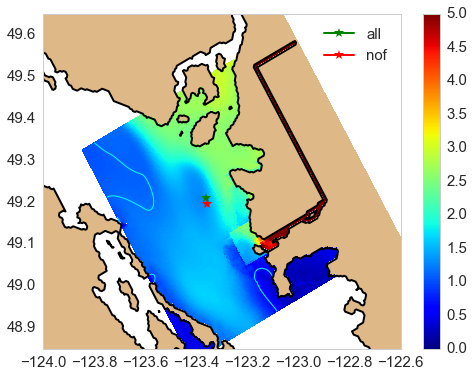

In [11]:
jpos_oct,ipos_oct = plot_plume_position(octall_T,octnof_T,48,143,10,0,['all','nof'])

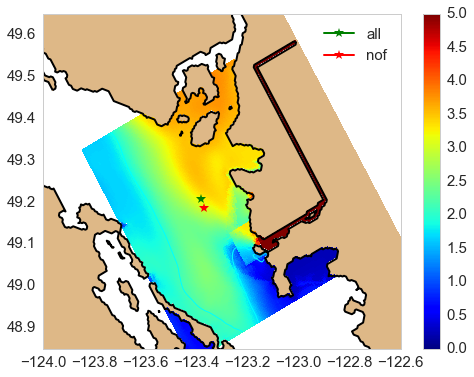

In [12]:
jpos_may,ipos_may = plot_plume_position(mayall_T,maynof_T,192,263,10,0,['all','nof'])

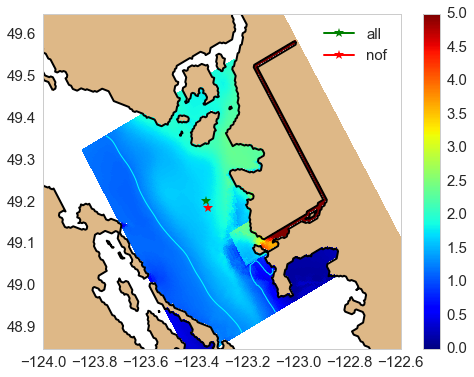

In [13]:
jpos_jan,ipos_jan = plot_plume_position(janall_T,jannof_T,168,239,10,0,['all','nof'])

# Wind effects

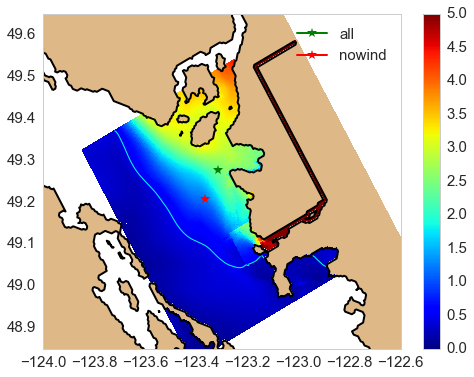

In [14]:
## wind from south blow to north oct high
jpos_oct_wind,ipos_oct_wind = plot_plume_position(octall_T,octnowind_T,480,551,10,0,['all','nowind'])

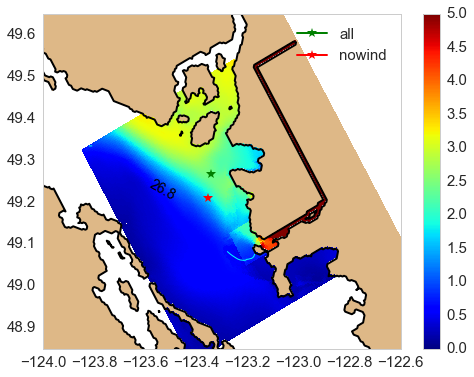

In [61]:
## wind from south blow to north oct moderate
jpos_oct_windMo,ipos_oct_windMo = plot_plume_position(octall_T,octnowind_T,408,480,10,0,['all','nowind'])

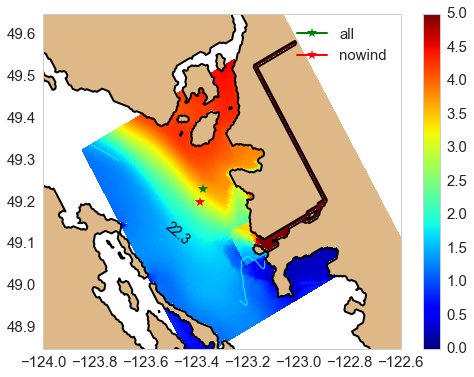

In [48]:
## wind from south blow to north, moderate may
jpos_may_windNW,ipos_may_windNW = plot_plume_position(mayall_T,maynowind_T,288,359,10,0,['all','nowind'])

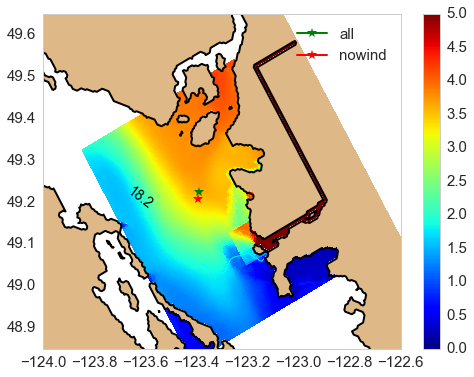

In [69]:
## wind from north blow to south, moderate may 
jpos_may_windSE,ipos_may_windSE = plot_plume_position(mayall_T,maynowind_T,360,455,10,0,['all','nowind'])

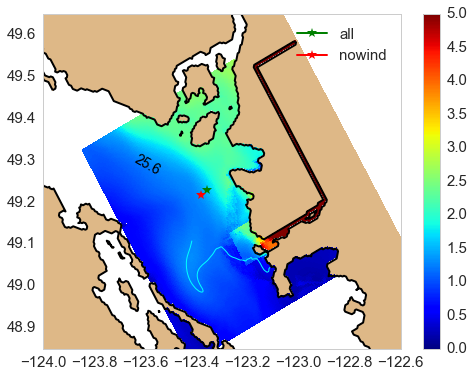

In [53]:
## wind from south blow to north, high Jan
jpos_jan_windHi,ipos_jan_windHi = plot_plume_position(janall_T,jannowind_T,624,671,10,0,['all','nowind'])

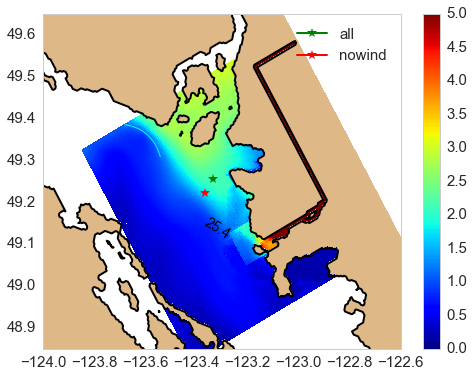

In [57]:
## wind from south blow to north, moderate Jan
jpos_jan_windMo,ipos_jan_windMo = plot_plume_position(janall_T,jannowind_T,384,455,10,0,['all','nowind'])

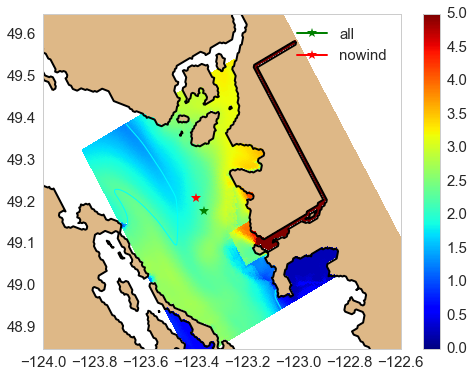

In [21]:
## wind from north blow to south
jpos_may_wind,ipos_may_wind = plot_plume_position(mayall_T,maynowind_T,24,95,10,0,['all','nowind'])